In [1]:
import torch
from supervoice_valle import SupervoceNARModel, Tokenizer
from train.dataset import load_sampler
from IPython.display import Audio, display
import matplotlib.pyplot as plt
from vocos import Vocos

In [2]:
vocos = Vocos.from_pretrained("charactr/vocos-encodec-24khz")
tokenizer = Tokenizer("./tokenizer_text.model")
sampler = load_sampler("./external_datasets/libriheavy/libriheavy_cuts_small.jsonl.gz", "./external_datasets/libriheavy-encodec/", 1, tokenizer)
model = SupervoceNARModel()
checkpoint = torch.load("./output/valle-30.pt", map_location = "cpu")
model.load_state_dict(checkpoint['model'])
# model = model.to(torch.float16)
# model = model.to("cuda")
model.eval()
step = checkpoint['step']
print(checkpoint['step'])

/home/steve/miniconda/envs/gym/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


24000


In [3]:
audio, text = sampler()
print(audio[0], text[0])
encoded = audio[0]
text = text[0]
# id = "./external_datasets/libriheavy-encodec/9774/extermination_american_bison_1503_librivox_64kb_mp3/exterminationamericanbison_12_hornaday_64kb_99"
# with open(id + ".txt", 'r') as file:
#     text = file.read()
#     text = tokenizer.encode(text)
# encoded = torch.load(id + ".pt")

tensor([[ 475,  475,  475,  ...,  276,  779,  208],
        [ 961,  544,  544,  ...,  226,  859,  740],
        [ 842,  842,   36,  ...,  673,  675,  915],
        ...,
        [ 494,   19,  505,  ...,   59,  699,  461],
        [ 748,  365,  782,  ...,  304,  304,  764],
        [1012,  937,  468,  ...,  237,  639,  558]]) tensor([ 331, 2198,   71,  384,  327,   10,   52,  167,  353, 3638,   10,   60,
        2746,   52,  359,   56, 1083,  577,   52,  309,   71,  795,   42,  435,
          52,   33,  309,   71,   89,   18,  360,   52,  309,  353,   52,  139,
         244,   10,  112,   52,  125,  425,   42,  281,   11,   89,   10,  597,
         420,   19,   98,  699,  309,   17,   33,   52,  309,  353,   52,   42,
          71, 1419, 1742,   10,  194,  185,  217,   42,  193,   71,   42,   94,
          52,  241, 4249,   71,  167,   69,   10,   17,  955,   91,  167,   62,
         146,   52,  343, 1169,  282,  437,  194,   71,  121,   13,  224,   11,
          89,  281,   10,   52,  2

In [4]:
def decode(tokens):
    features = vocos.codes_to_features(tokens)
    bandwidth_id = torch.tensor([2])  # 6 kbps
    return vocos.decode(features, bandwidth_id=bandwidth_id)
display(Audio(data=decode(encoded).cpu(), rate=24000))
print(encoded.shape)

torch.Size([8, 1923])


In [5]:
condition_text = text
condition_audio = encoded[:,:75*3]
audio = encoded[:,75*3:]
predicted = [audio[0]]
print(audio[0])
for i in range(1, 8):
    p = model(
        condition_text = [condition_text], 
        condition_audio = [condition_audio],
        audio = [torch.stack(predicted)],
        codec = [i]
    )

    p = p[0]
    p = torch.nn.functional.softmax(p, dim=-1)
    # print(p.shape)

    # for j in range(len(audio[i])):
    #     print(p[j][audio[i][j]].item(), torch.max(p[j]).item())

    # Top-3
    # p = p[0]
    # v, _ = torch.topk(p.unsqueeze(0), 10)
    # v = v.squeeze(0)
    # p[p < v[:, [-1]]] = -float('Inf')

    # Sample
    p = torch.nn.functional.softmax(p, dim=-1)
    # p = torch.multinomial(p, num_samples=1)
    # p = p.squeeze(-1)

    p = torch.argmax(p, dim=-1, keepdim=True)
    p = p.squeeze(-1)

    print("inference")
    print(p)
    print(audio[i])
    predicted.append(p.cpu())
predicted = torch.stack(predicted)
predicted = torch.cat([condition_audio, predicted], dim = 1)
display(Audio(data=decode(predicted).cpu(), rate=24000))

tensor([ 738, 1017,  738,  ...,  276,  779,  208])
inference
tensor([424, 424, 424,  ..., 646, 544, 646])
tensor([363, 913, 913,  ..., 226, 859, 740])
inference
tensor([ 36,  36,  36,  ..., 936,  36, 705])
tensor([880, 797, 989,  ..., 673, 675, 915])
inference
tensor([ 741,  741,  741,  ...,  762,  741, 1022])
tensor([ 36, 956, 215,  ..., 558, 842, 993])
inference
tensor([448, 622, 622,  ..., 862, 622, 862])
tensor([963, 904, 606,  ..., 969, 142, 959])
inference
tensor([939, 939, 435,  ...,  19, 939,  41])
tensor([ 701,  632, 1011,  ...,   59,  699,  461])
inference
tensor([1002,  570,  570,  ...,  772,  900,  772])
tensor([444, 782, 900,  ..., 304, 304, 764])
inference
tensor([975, 948, 948,  ..., 701, 518, 701])
tensor([818, 393, 475,  ..., 237, 639, 558])


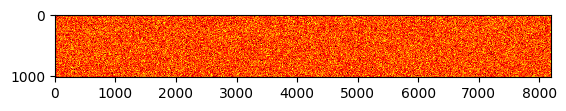

In [6]:
plt.imshow(model.positional_embedding_text.weight.T.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

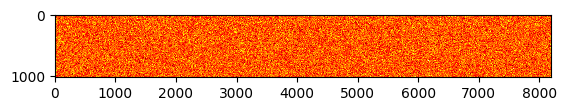

In [7]:
plt.imshow(model.positional_embedding_audio.weight.T.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.show()

In [8]:
# for i in range(step - 40000, step, 5000):
#     checkpoint = torch.load("./output/valle-23." + str(i) + ".pt", map_location = "cpu")
#     model.load_state_dict(checkpoint['model'])

#     condition_text = text
#     condition_audio = encoded[:,:75*3]
#     audio = encoded[:,75*3:]
#     predicted = [audio[0]]
#     for i in range(1, 8):
#         p = model(
#             condition_text = [condition_text], 
#             condition_audio = [condition_audio],
#             audio = [torch.stack(predicted)],
#             codec = [i]
#         )
#         p = p[0]
#         p = torch.nn.functional.softmax(p, dim=-1)
#         p = torch.argmax(p, dim=-1, keepdim=True)
#         p = p.squeeze(-1)
#         predicted.append(p.cpu())
#     predicted = torch.stack(predicted)
#     predicted = torch.cat([condition_audio, predicted], dim = 1)
#     display(Audio(data=decode(predicted).cpu(), rate=24000))